In [1]:
#Nate's Image Compression

from scipy import linalg as la
import numpy as np
from matplotlib import pyplot as plt
from imageio import imread
import pdb

This is a function to find the SVD of a given matrix

In [2]:
def compact_svd(A, tol=1e-6):
    """Compute the truncated SVD of A.

    Parameters:
        A ((m,n) ndarray): The matrix (of rank r) to factor.
        tol (float): The tolerance for excluding singular values.

    Returns:
        ((m,r) ndarray): The orthonormal matrix U in the SVD.
        ((r,) ndarray): The singular values of A as a 1-D array.
        ((r,n) ndarray): The orthonormal matrix V^H in the SVD.
    """
    #Calculate eigenvalues and eigenvectors of (A^H)A
    lamb,V = la.eig((A.conj().T)@A)
    #Calculate singular values of A
    sigma = np.sqrt(lamb)
    #Sort singular values from greatest to least
    sigma = np.sort(sigma)[::-1]
    #Sort V the *same way*!!!!!!
    V = V[np.argsort(sigma)[::-1]]
    #Count the number of nonzero singular val's (greater than the tol)
    mask = sigma > tol
    r = len(sigma[mask])
    #Keep only the positive singular values and corresponding eigenvectors
    sigma_new = sigma[:r]
    V_new = V[:,:r]
    #Construct U
    U = (A@V_new)/sigma_new

    return U,sigma_new,V_new.conj().T

In [3]:
#Let's do an example of getting an SVD and test it against scipy.linalg.svd()

#A is random
A = np.random.random((10,5))
U,sig,VH = compact_svd(A)

#Let's test some properties 
#V^H@V should be the identity
print(np.allclose(VH@VH.T,np.eye(5)))
#U@SIG@VH should equal A
print(np.allclose(U@np.diag(sig)@VH,A))
#sig should have length of the rank of A
print(np.linalg.matrix_rank(A) == len(sig))

True
True
True


The matrix A, equal to U@Sigma@V^H transforms a vector linearly. Each component of the SVD actually does something different. the V^H performs a rotation on the vector. The Sigma rescales, and the U rotates again. This function can help us visualize that (my deforming a circle).

In [4]:
def visualize_svd(A):
    """Plot the effect of the SVD of A as a sequence of linear transformations
    on the unit circle and the two standard basis vectors.
    """
    #    First we generate a 2 × 200 matrix S
    #    representing a set of 200 points on the unit circle,
    #    with x-coordinates on the top row and y-
    #    coordinates on the bottom row
    
    theta = np.linspace(0,2*np.pi,201)
    theta = theta[:-1]
    x = np.cos(theta)
    y = np.sin(theta)
    S = np.vstack((x,y))
    #Now we create E
    #This set of 3 vectors (essentially) will give us 3 points, or 2
    #line-segments, which can help us see how the circle is deformed.
    #You'll see....
    E = np.array([[1,0,0],[0,0,1]])
    #Now we get the svd of A
    U,sing,VH = la.svd(A)
    SIG = np.diag(sing)

    #Now we plot everything
    #Original graph (1 of 4 subplots)
    ax1 = plt.subplot(221)
    #Circle
    ax1.plot(S[0,:],S[1,:])
    #Line-segments
    ax1.plot(E[0,:],E[1,:])
    ax1.set_title("Original")
    plt.axis('equal')

    #1 rotation
    #Left-multiply by VH and plot again
    S = VH@S
    E = VH@E
    ax2 = plt.subplot(222)
    ax2.plot(S[0,:],S[1,:])
    ax2.plot(E[0,:],E[1,:])
    ax2.set_title("Rotate")
    plt.axis('equal')

    #1 re-scale
    #Left-multiply by SIG and plot again
    S = SIG@S
    E = SIG@E
    ax3 = plt.subplot(223)
    ax3.plot(S[0,:],S[1,:])
    ax3.plot(E[0,:],E[1,:])
    ax3.set_title("Scale")
    plt.axis('equal')

    #another rotation
    #Left-multiply by U and plot again
    S = U@S
    E = U@E
    ax4 = plt.subplot(224)
    ax4.plot(S[0,:],S[1,:])
    ax4.plot(E[0,:],E[1,:])
    ax4.set_title("Rotate again")
    plt.axis('equal')
    
    #So things can look nice...
    plt.tight_layout()

    plt.show()

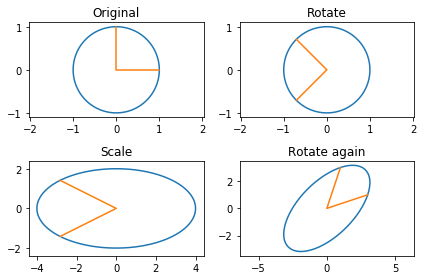

In [5]:
#Let's see what that ^ function does!

#Pick some A 
A = np.array([[3,1],[1,3]])
visualize_svd(A)

This next function gives us a low-rank approximation for the matrix A. We find this by taking the SVD of A. Then given a value s, we truncate the SVD by cutting off all but the first s columns of U, first s rows of V^H, and first s entries of sig. Then when we multiply the resulting smaller matrices together, we get A_s, which is the closest rank-s matrix to A in the 2-norm and Frobenius-norm.

In [6]:
def svd_approx(A, s):
    """Return the best rank s approximation to A with respect to the 2-norm
    and the Frobenius norm, along with the number of bytes needed to store
    the approximation via the truncated SVD.

    Parameters:
        A ((m,n), ndarray)
        s (int): The rank of the desired approximation.

    Returns:
        ((m,n), ndarray) The best rank s approximation of A.
        (int) The number of entries needed to store the truncated SVD.
    """
    #The rank of A is len(sing[sing>0])
    U,sing,VH = la.svd(A)
    rank_A = len(sing[sing>0])
    #Check if s is okay (are we decreasing the rank?)
    if s > rank_A:
        raise ValueError("Value of s cannot be bigger than the rank of A")

    #Let's chop those matrices to be smaller
    U = U[:,:s]
    sing = sing[:s]
    VH = VH[:s,:]

    #turn the list of singular val's into a matrix
    SIG = np.diag(sing)
    #Get the approximation
    A_s = U@SIG@VH

    #We return A_s and also the amount of memory it takes to store the SVD of A_s
    return A_s, (U.size + len(sing) + VH.size)

This next function will compute the lowest rank approximation A_s of A with a 2-norm error la.norm(A_s-A) less than the given tolerance err. This will come in handy when compressing images

In [7]:
def lowest_rank_approx(A, err):
    """Return the lowest rank approximation of A with error less than 'err'
    with respect to the matrix 2-norm, along with the number of bytes needed
    to store the approximation via the truncated SVD.

    Parameters:
        A ((m, n) ndarray)
        err (float): Desired maximum error.

    Returns:
        A_s ((m,n) ndarray) The lowest rank approximation of A satisfying
            ||A - A_s||_2 < err.
        (int) The number of entries needed to store the truncated SVD.
    """
    
    #We want the SVD of A 
    U,sing,VH = la.svd(A)

    #If the err is smaller than the smallest singular value of A, there will be no A_s
    if len(sing[sing<err]) == 0:
        raise ValueError("That value of err is smaller than the smallest singular value.")

    #Now we gotta choose s (close to the tolerance as can be - we want it small)
    s_ = len(sing[sing>=err])

    #Let's chop those matrices to be smaller like before
    U = U[:,:s_]
    sing = sing[:s_]
    VH = VH[:s_,:]

    #turn the list of singular val's into a matrix
    SIG = np.diag(sing)
    #Get the approximation
    A_s = U@SIG@VH
    #We also want the amount of memory used to store this truncated SVD
    size_ = (U.size + len(sing) + VH.size)

    return A_s, size_

This function takes the filename of an image and plots a lower-rank (rank-s) compression of the image. Note that previous functions show that a lower-rank approximation takes up less memory. This function can handle color or black-and-white images.

In [8]:
def compress_image(filename, s):
    """Plot the original image found at 'filename' and the rank s approximation
    of the image found at 'filename.' State in the figure title the difference
    in the number of entries used to store the original image and the
    approximation.

    Parameters:
        filename (str): Image file path.
        s (int): Rank of new image.
    """
    #Read in the image. We need to scale this from a 0-255 scale to a 0-1 scale.
    image = imread(filename)/255.

    #We gotta check if this puppy is color or not

    #-----Black and white------------------------
    if len(image.shape) == 2:
        #Get the smaller image
        approx, smallsize = svd_approx(image,s)
        approx = np.clip(approx,0,1)

        #original image
        ax1 = plt.subplot(121)
        plt.imshow(image,cmap = 'gray')
        plt.axis("off")

        #compressed image
        ax2 = plt.subplot(122)
        plt.imshow(approx,cmap = 'gray')
        plt.axis("off")
        plt.suptitle("Size difference: "+ str(image.size-smallsize))



    #-----Color----------------------------------
    elif len(image.shape) == 3:
        #Split the image into red, blue, green
        R,B,G = image[:,:,0], image[:,:,1], image[:,:,2]

        #Get the compressed versions of each color
        approx_r, smallsize_r = svd_approx(R,s)
        approx_b, smallsize_b = svd_approx(B,s)
        approx_g, smallsize_g = svd_approx(G,s)

        #Now we put them together
        approx = np.dstack((approx_r,approx_b,approx_g))
        approx = np.clip(approx,0,1)
        #We find the difference in memory
        smallsize = smallsize_r+smallsize_b+smallsize_g

        #original image
        ax1 = plt.subplot(121)
        plt.imshow(image)
        plt.axis("off")

        #Compressed image
        ax2 = plt.subplot(122)
        plt.imshow(approx)
        plt.axis("off")
        plt.suptitle("Size difference: "+ str(image.size-smallsize))


    #After all
    plt.show()

Images in color and black-and-white with rank 100, 20, 2 compressions. The "size difference" is the difference in memory, in terms of how many matrix entries to store. 

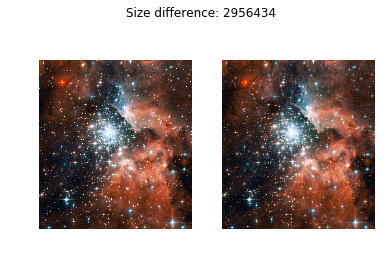

In [11]:
compress_image("hubble.jpg",100)

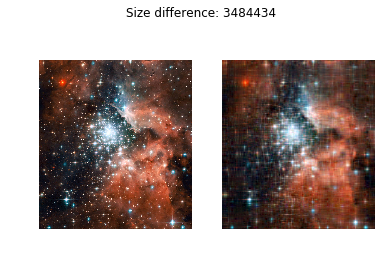

In [17]:
compress_image("hubble.jpg",20)

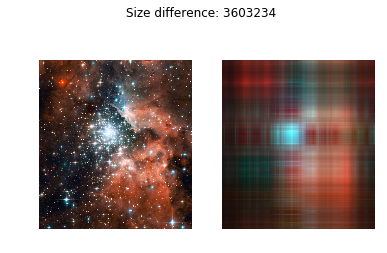

In [15]:
compress_image("hubble.jpg",2)

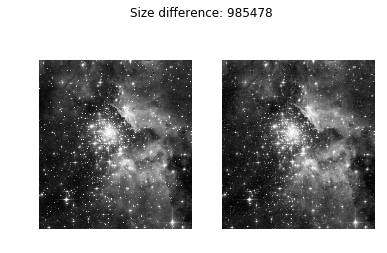

In [18]:
compress_image("hubble_gray.jpg",100)

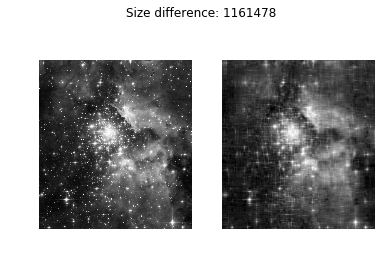

In [19]:
compress_image("hubble_gray.jpg",20)

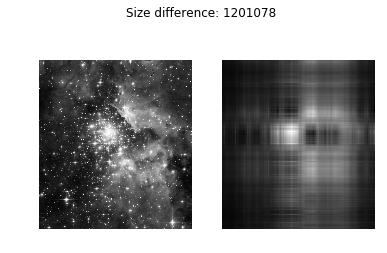

In [20]:
compress_image("hubble_gray.jpg",2)